<a href="https://colab.research.google.com/github/jameson-c/Code-Samples/blob/main/Jameson_Carter_94889_preliminary_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 94889 Preliminary Exercise

## Overview

The purpose of this exercise is to provide a quick check on a couple of the technical skills you'll need in Machine Learning for Public Policy Lab (94-889) anbd help us make sure everyone coming in has the necessary pre-requisites including python, data analysis, databases/sql, and machine learning. 

Feel free to use any references (previous class notes, google, stackoverflow, etc) you would like, but please complete the exercise on your own to ensure the work reflects your experience. **Completing this notebook should take you under 2 hours** -- if you're finding you need to take significantly more time on, you may find it difficult to contribute to the project work in the class.

## Problem Background

This notebook makes use of a sample of the data provided by [DonorsChoose](https://www.donorschoose.org/) to the [2014 KDD Cup](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data). Public schools in the United States face large disparities in funding, often resulting in teachers and staff members filling these gaps by purchasing classroom supplies out of their own pockets. DonorsChoose is an online crowdfunding platform that tries to help alleviate this financial burden on teachers by allowing them to seek funding for projects and resources from the community (projects can include classroom basics like books and markers, larger items like lab equipment or musical instruments, specific experiences like field trips or guest speakers). Projects on DonorsChoose expire after 4 months, and if the target funding level isn't reached, the project receives no funding. Since its launch in 2000, the platform has helped fund over 2 million projects at schools across the US, but about 1/3 of the projects that are posted nevertheless fail to meet their goal and go unfunded.

### The Modeling Problem

For the purposes of this exercise, we'll imagine that DonorsChoose has hired a digital content expert who will review projects and help teachers improve their postings and increase their chances of reaching their funding threshold. Because this individualized review is a labor-intensive process, the digital content expert has time to review and support only 10% of the projects posted to the platform on a given day. 

You are a data scientist working with DonorsChoose, and your task is to help this content expert focus their limited resources on projects that most need the help. As such, you want to build a model to identify projects that are least likely to be fully funded before they expire and pass them off to the digital content expert for review.


# Getting Set Up

Running the code below will create a local postgres 11 database for you and import the sampled donors choose data. Don't worry about the details of that and you shouldn't need to touch any of the code here aside from running it. Below, we'll talk about how to access the database from within the notebook to run queries.

In [3]:
# Install and start postgresql-11 server
!sudo apt-get -y -qq update
!wget --quiet -O - https://www.postgresql.org/media/keys/ACCC4CF8.asc | sudo apt-key add -
!echo "deb http://apt.postgresql.org/pub/repos/apt/ `lsb_release -cs`-pgdg main" |sudo tee  /etc/apt/sources.list.d/pgdg.list
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql-11 postgresql-client-11
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

# Setup a database with name `donors_choose` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS donors_choose;'

!sudo -u postgres psql -U postgres -c 'CREATE DATABASE donors_choose;'

# Environment variables for connecting to the database
%env DEMO_DATABASE_NAME=donors_choose
%env DEMO_DATABASE_HOST=localhost
%env DEMO_DATABASE_PORT=5432
%env DEMO_DATABASE_USER=postgres
%env DEMO_DATABASE_PASS=postgres

OK
deb http://apt.postgresql.org/pub/repos/apt/ bionic-pgdg main
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 16.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package cron.
(Reading database ... 155680 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128.1ubuntu1.2_amd64.deb ...
Unpacking cron (3.0pl1-128.1ubuntu1.2) ...
Selecting previously unselected package logrotate.
Preparing to unpack .../01-logrotate_3.11.0-0.1ubuntu1_amd64.deb ...
Unpacking logrotate (3.11.0-0.1ubuntu1) ...
Selecting previously unselected package netbase.
Preparing to unpack .../02-netbase_5.4_all

In [4]:
# Download sampled DonorsChoose data and load it into our postgres server
!curl -s -OL https://dsapp-public-data-migrated.s3.us-west-2.amazonaws.com/donors_sampled_20210920_v3.dmp
!PGPASSWORD=$DEMO_DATABASE_PASS pg_restore -h $DEMO_DATABASE_HOST -p $DEMO_DATABASE_PORT -d $DEMO_DATABASE_NAME -U $DEMO_DATABASE_USER -O -j 8 donors_sampled_20210920_v3.dmp

In [5]:
!pip install SQLAlchemy==1.3.18 PyYAML==6.0 psycopg2-binary==2.9.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 48.5 MB/s 
     |████████████████████████████████| 3.0 MB 38.6 MB/s 
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 1.4.39
    Uninstalling SQLAlchemy-1.4.39:
      Successfully uninstalled SQLAlchemy-1.4.39
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [7]:
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine

db_url = URL(
            'postgres',
            host='localhost',
            username='postgres',
            database='donors_choose',
            password='postgres',
            port=5432,
        )

db_engine = create_engine(db_url)

# Querying the Database

The code block above used the `sqlalchemy` module to create a connection to the database called `db_engine`. An easy way to run SQL queries against this database is to use the `read_sql` command provided by `pandas`. For instance, if you run the example below, it should return the number of projects in the sampled dataset (16,480):

In [6]:
pd.read_sql("SELECT COUNT(*) FROM data.projects", db_engine)

,count
0,16480


You can find some more details about the dataset on the [KDD Cup page](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data), but here is a quick description of the four main source tables:
- `data.projects` contains information about each project that was posted on the site, including IDs for the project, school, and teacher, as well as the total amount being requested (note that projects can also request additional "optional support" but don't need to reach this higher bar to be funded)
- `data.essays` has project titles and descriptions
- `data.resources` has information about the specific resources being requested
- `data.donations` contains details about each donation that was received by a project (when it came in, the amount, whether it was from another teacher, etc.)

## Want other packages?
If you need to install any other python modules for your analysis, you can easily do so from a code block by prefixing your `pip install` command with an `!` character. For instance:
```
!pip install PyYAML
```

# QUESTION 1

**(A)** Write a query to return the school id, title, short description, date posted, and total asking price for the most recently posted project from each school in Oregon.

In [8]:
pd.read_sql("""SELECT pr.schoolid, es.title, es.short_description, 
                      es.date_posted, pr.total_asking_price
               FROM data.projects pr
               JOIN data.essays es ON pr.projectid_str = es.projectid_str 
               WHERE pr.school_state = 'OR' AND
               (pr.schoolid, es.date_posted) IN
               
                  (SELECT schoolid, MAX(date_posted)
                   FROM data.projects 
                   GROUP BY schoolid)
               """, db_engine)

,schoolid,title,short_description,date_posted,total_asking_price
0,d61b06fffec84e74406fd9b79b83f676,STEM Towers Engineering Project,"Build it and they will come!"" Students will ha...",2013-08-27,648.93
1,e86e6f6826167263fe4c358ce12eb21f,Academic English,My students are learning English as a second l...,2013-02-19,198.98
2,ca7c1b50e18e22c9c97e91d429cbaca8,Scrabble Wars,"Language shapes the way we think, and determin...",2012-12-08,301.22
3,2fb6bd29ba665d9e98727a52753477c5,Recycling Project,"Robert Alanr said, ""We can help educate our fa...",2011-02-15,495.59
4,e5119574d9b41fb7200594899f23ba41,Technology to Increase Student Learning,My students are getting more exposure to diffe...,2013-09-03,793.06
5,d61b06fffec84e74406fd9b79b83f676,STEM Green Chemical Engineering Project,"Teaching at a public, science magnet school, o...",2013-08-27,327.64
6,b688c7b721152811d3012ef4493676c0,Help Us Buy Quality Literature For Our English...,"As a new school, we are working to build our c...",2012-01-09,452.65
7,28af7a22c4a224d9450b9b7aee7261e7,Lifting Our Way to a Healthier Day,My students are looking for new ways to build ...,2011-11-13,598.57
8,16c2e091c46696b6af2321a68fc9f53a,iPad Differentiation!,Do you remember the first time you had the abi...,2013-10-06,1665.96
9,c3d3bd57df48d9f90fe71d66139a0830,Measuring Up the Greenhouse,Nothing is more rewarding than watching life h...,2012-07-31,619.26


**(B)** Create a scatter plot of the number of resources requested vs fraction of the total ask amount that was funded across all projects in New Hampshire. (Hint: You'll need to join a couple of tables here to figure out the amount donated to a project)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

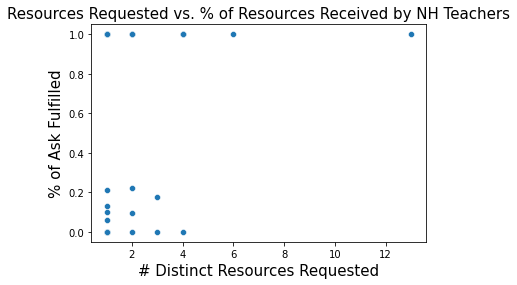

In [10]:
data = pd.read_sql("""
                   WITH projects AS(
                     SELECT projectid_str, total_asking_price
                     FROM data.projects
                     WHERE school_state = 'NH'),

                     donations AS(
                     SELECT SUM(donation_to_project) AS tot_fulfilled, projectid_str
                     FROM data.donations
                     GROUP BY projectid_str),

                     resources AS(
                     SELECT COUNT(resourceid) AS num_resources, projectid_str
                     FROM data.resources 
                     GROUP BY projectid_str)

                     SELECT projects.total_asking_price, 
                            COALESCE(donations.tot_fulfilled,0)/projects.total_asking_price AS pct_fulfilled,
                            resources.num_resources
                     FROM projects LEFT JOIN donations ON projects.projectid_str = donations.projectid_str
                     JOIN resources ON projects.projectid_str = resources.projectid_str
                     """, db_engine)

plot = sns.scatterplot(x="num_resources",
                    y="pct_fulfilled",
                    data=data)


plot.set_xlabel("# Distinct Resources Requested",fontsize=15)
plot.set_ylabel("% of Ask Fulfilled",fontsize=15)
plot.set_title("Resources Requested vs. % of Resources Received by NH Teachers",fontsize=15)

plt.show()

# QUESTION 2

For this question, you'll develop a model to help DonorsChoose identify 10% of projects to have their digital content expert review based on their risk of failing to reach their funding goal. In order to intervene early in the process, DonorsChoose wants to identify these projects to help immediately upon being posted to the site.

Build and evaluate the performance of a handful of machine learning models. **Be sure to use comments or text blocks to discuss the choices and assumptions you're making along the way.** Note that you don't need to explore an extensive model space here -- building 3 or 4 models should be fine for the purposes of this exercise. Feel free to use any python packages available (such as sklearn) for this.

In [28]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import metrics, preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [107]:
'''
Goal: Identify projects based on risk of failing to reach goal. Identify high-risk projects.
Output: risk scores, basically the bottom 10% of projects according to their probabilities of being funded
Granularity: At the project level.

ASSUMPTIONS: 
- I make the assumption that any project posted prior to 2014-01-01 is the training and test because outcomes are only available for those projects
- I assume that no hyperparameter tuning is necessary due to the time constraints of the exercise.
- I conduct no feature selection due to time constraints, and remove massive categorical variables
'''

# Data Wrangling

In [12]:
# Extracting Data
data = pd.read_sql("""
                   WITH projects AS(
                     SELECT *
                     FROM data.projects),

                     outcomes AS(
                     SELECT fully_funded, projectid_str 
                     FROM data.outcomes),

                     resources AS(
                     SELECT COUNT(resourceid) AS num_resources, projectid_str
                     FROM data.resources 
                     GROUP BY projectid_str)

                     SELECT *
                     FROM outcomes LEFT JOIN projects ON outcomes.projectid_str = projects.projectid_str
                     LEFT JOIN resources ON outcomes.projectid_str = resources.projectid_str
                     """, db_engine)

data

,fully_funded,projectid_str,schoolid,projectid_str,teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_asking_price,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,entity_id,num_resources,projectid_str
0,True,30c034618e67d00c641f9b5b7775c0f4,29a2da790e38b6c8a1c70aced6b9c765,30c034618e67d00c641f9b5b7775c0f4,0903da60e148adc6280d55f5d94791a5,192013001182,41.428391,-91.049135,Muscatine,IA,52761,None,Muscatine Cmty School District,Muscatine,False,False,False,False,False,False,Ms.,False,False,Applied Sciences,Math & Science,College & Career Prep,Applied Learning,Supplies,high poverty,Grades 6-8,35.0,511.32,601.55,100,False,False,2012-08-06,234148,7.0,30c034618e67d00c641f9b5b7775c0f4
1,True,94199c544d9d2926c1820e5c6cde1eb6,06ef48acbdf9b013d4bc4bfc8d328cc1,94199c544d9d2926c1820e5c6cde1eb6,fb340c7ac3b22a5984c6a82602e4a510,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,Beaufort Co School District,Beaufort,False,False,False,False,False,False,Ms.,False,False,Literacy,Literacy & Language,ESL,Literacy & Language,Supplies,high poverty,Grades 3-5,35.0,167.43,192.45,40,False,False,2010-07-10,453579,2.0,94199c544d9d2926c1820e5c6cde1eb6
2,True,61f42f174afef1ed2419ab948a647137,06ef48acbdf9b013d4bc4bfc8d328cc1,61f42f174afef1ed2419ab948a647137,fb340c7ac3b22a5984c6a82602e4a510,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,Beaufort Co School District,Beaufort,False,False,False,False,False,False,Ms.,False,False,Literacy,Literacy & Language,Applied Sciences,Math & Science,Other,high poverty,Grades 3-5,35.0,167.43,196.98,45,False,False,2011-06-09,353855,2.0,61f42f174afef1ed2419ab948a647137
3,True,c966f5226f42aaaf6b115d7dbaefdea3,06ef48acbdf9b013d4bc4bfc8d328cc1,c966f5226f42aaaf6b115d7dbaefdea3,e0b5a72f41a376b28db9c2e838a24de5,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,Beaufort Co School District,Beaufort,False,False,False,False,False,False,Mrs.,False,False,Literacy,Literacy & Language,Health & Life Science,Math & Science,Other,high poverty,Grades 3-5,35.0,162.14,190.75,25,False,False,2011-06-13,353178,2.0,c966f5226f42aaaf6b115d7dbaefdea3
4,False,69e9c24111daa1e6ba64c6d5538e4df1,06ef48acbdf9b013d4bc4bfc8d328cc1,69e9c24111daa1e6ba64c6d5538e4df1,32e86c49396707f71fdc0398ab2b844b,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,Beaufort Co School District,Beaufort,False,False,False,False,False,False,Mrs.,False,False,History & Geography,History & Civics,Environmental Science,Math & Science,Books,high poverty,Grades 3-5,35.0,381.27,448.55,25,False,False,2012-07-15,239363,9.0,69e9c24111daa1e6ba64c6d5538e4df1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15234,True,94ddd7a85d46526f772dd84ce4f2450d,dde161252564ad07a75b072f0f90705f,94ddd7a85d46526f772dd84ce4f2450d,3acc2ac0c3cc25fecc814afaff4f3696,120039000435,25.835409,-80.215416,Miami,FL,33150,None,Miami-dade Co Public Sch Dist,Miami-Dade,False,False,False,False,False,False,Ms.,True,False,Literacy,Literacy & Language,None,None,Supplies,highest poverty,Grades 3-5,30.0,689.47,811.14,19,True,False,2013-10-17,79543,7.0,94ddd7a85d46526f772dd84ce4f2450d
15235,True,26dd4c75d1878240d1e420e8fb0905bb,dde161252564ad07a75b072f0f90705f,26dd4c75d1878240d1e420e8fb0905bb,1d132065e38edd88143f88c8df639724,120039000435,25.835409,-80.215416,Miami,FL,33150,None,Miami-dade Co Public Sch Dist,Miami-Dade,False,False,False,False,False,False,Mrs.,False,False,Literacy,Literacy & Language,N

In [63]:
'''Data Cleaning'''
data.info() # I decide to drop secondary_focus_subject, secondary_focus_area, fulfillment_labor_materials
# school_metro, school_ncesid, due to missingness and duplicity of the NCES ID with schoolID
# Also, I drop some variables that are large categorical variables which would create giant dummy variables if expanded
# And I drop identifiers
X = data.drop(['secondary_focus_subject', 'secondary_focus_area',
                   'fulfillment_labor_materials','school_metro', 'school_ncesid',
               'school_zip', 'schoolid', 'projectid_str', 'projectid_str','projectid_str',
               'entity_id','school_city', 'teacher_acctid','date_posted'], axis= 1)
X = X.dropna(axis=1) # Drop the three observations that are missing values
y = X['fully_funded'].astype(int) # Convert to binary and get response variable
X = X.drop(['fully_funded'], axis= 1) # Drop response

# Convert categorical variables to dummy variables
X = pd.get_dummies(data= X, 
                   columns = ['school_state','school_district',
                              'school_county','teacher_prefix','primary_focus_subject',
                              'primary_focus_area','resource_type','poverty_level',
                              'grade_level'], 
                   prefix = ['st','dist','cnty','tch','subj','subjar','typ',
                             'pov', 'grade'], drop_first=True)
# Establishing test and train set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15239 entries, 0 to 15238
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   fully_funded                            15239 non-null  bool          
 1   projectid_str                           15239 non-null  object        
 2   schoolid                                15239 non-null  object        
 3   projectid_str                           15239 non-null  object        
 4   teacher_acctid                          15239 non-null  object        
 5   school_ncesid                           15214 non-null  object        
 6   school_latitude                         15239 non-null  float64       
 7   school_longitude                        15239 non-null  float64       
 8   school_city                             15239 non-null  object        
 9   school_state                            15239 non-

# Modeling


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


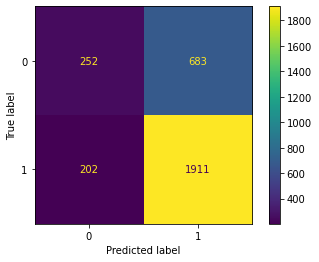

In [64]:
'''Model 1: Logistic Regression'''
logmod = LogisticRegression(max_iter = 1000) # initialize model
logmod.fit(X_train, y_train) # fit model
predictedlog = logmod.predict(X_test) # predict results

cm = confusion_matrix(y_test, predictedlog, labels=logmod.classes_) # create confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logmod.classes_)
disp.plot()

In [65]:
# Present statistics of the model- Accuracy and precision are ok, false positives are a problem
print("Accuracy: ", str(metrics.accuracy_score(y_test, predictedlog)))
print("Precision: ", metrics.precision_score(y_test, predictedlog, average=None)[1])
print(classification_report(y_test, predictedlog, digits=3))

Accuracy:  0.7096456692913385
Precision:  0.7367000771010023
              precision    recall  f1-score   support

           0      0.555     0.270     0.363       935
           1      0.737     0.904     0.812      2113

    accuracy                          0.710      3048
   macro avg      0.646     0.587     0.587      3048
weighted avg      0.681     0.710     0.674      3048



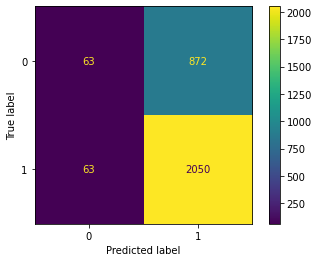

In [16]:
'''Model 2: Naive Bayes'''
nbmod = GaussianNB() # initialize model
nbmod.fit(X_train, y_train) # train model
predicted = nbmod.predict(X_test) # predict happiness

cm = confusion_matrix(y_test, predicted, labels=nbmod.classes_) # create confusion matrix data
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=nbmod.classes_) # produce confusion matrix plot
disp.plot() # display plot

In [17]:
# Present statistics of the model, accuracy and precision are even worse, bad false positive problem
print("Accuracy: ", str(metrics.accuracy_score(y_test, predicted)))
print("Precision: ", metrics.precision_score(y_test, predicted, average=None)[1])
print(classification_report(y_test, predicted, digits=3))

Accuracy:  0.693241469816273
Precision:  0.7015742642026009
              precision    recall  f1-score   support

           0      0.500     0.067     0.119       935
           1      0.702     0.970     0.814      2113

    accuracy                          0.693      3048
   macro avg      0.601     0.519     0.467      3048
weighted avg      0.640     0.693     0.601      3048



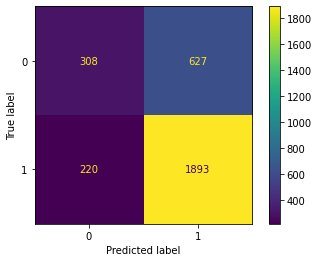

In [24]:
'''Model 3: Random Forest'''
RandForCls = RandomForestClassifier(n_estimators=500, random_state=1)
RandForCls.fit(X_train, y_train)

predicted = RandForCls.predict(X_test) # predict happiness

cm = confusion_matrix(y_test, predicted, labels=RandForCls.classes_) # create confusion matrix data
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=RandForCls.classes_) # produce confusion matrix plot
disp.plot() # display plot

In [25]:
# Present statistics of the model, accuracy and precision seem to be the best, true negatives are better selected than others
print("Accuracy: ", str(metrics.accuracy_score(y_test, predicted)))
print("Precision: ", metrics.precision_score(y_test, predicted, average=None)[1])
print(classification_report(y_test, predicted, digits=3))

Accuracy:  0.7221128608923885
Precision:  0.7511904761904762
              precision    recall  f1-score   support

           0      0.583     0.329     0.421       935
           1      0.751     0.896     0.817      2113

    accuracy                          0.722      3048
   macro avg      0.667     0.613     0.619      3048
weighted avg      0.700     0.722     0.696      3048



# Model Selection
It appears that the Random Forest model is performing the best based on the ROC curves below. The line for random forest models bend towards the ideal classifier across almost all threshold levels. This means that the tradeoff between sensitivity and specificity is best for the model, among those we have compared. To get a higher true positive rate, you have to endure fewer false positives for this model as compared to others.

Text(0, 0.5, 'TPR')

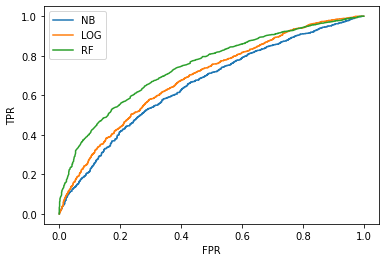

In [26]:
# ROC-AUC Curves for Model Selection
nbprobs = nbmod.predict_proba(X_test) # NB probabilities
logprobs = logmod.predict_proba(X_test) # Logistic probabilities
rfprobs = RandForCls.predict_proba(X_test) # Random forest probabilities


nbfpr, nbtpr, thresholds = roc_curve(y_test, nbprobs[:, 1]) # NB ROC curve
logfpr, logtpr, thresholds = roc_curve(y_test, logprobs[:, 1]) # Logistic ROC curve
rffpr, rftpr, thresholds = roc_curve(y_test, rfprobs[:, 1]) # Logistic ROC curve

# Plot the lines!
fig, ax = plt.subplots()
ax.plot(nbfpr, nbtpr, label=str('NB'))
ax.plot(logfpr, logtpr,label=str('LOG'))
ax.plot(rffpr, rftpr,label=str('RF'))
plt.legend(['NB','LOG','RF'])
plt.xlabel("FPR")
plt.ylabel("TPR")

# Model Cross-Validation
The random forest model performs the best over cross validation as well.

In [29]:
# Cross-Validation 
cv = KFold(n_splits=10, random_state=0, shuffle=True)
logmod = LogisticRegression()
cvacc = cross_val_score(logmod, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1) # cross-validate model
print(f'Logistic Regression CV Accuracy: {np.mean(cvacc)}, ({np.std(cvacc)})') # report outcome

cv = KFold(n_splits=10, random_state=0, shuffle=True)
nbmod = GaussianNB()
cvacc = cross_val_score(nbmod, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1) # cross-validate model
print(f'Naive Bayes CV Accuracy: {np.mean(cvacc)}, ({np.std(cvacc)})') # report outcome

cv = KFold(n_splits=10, random_state=0, shuffle=True)
rfmod = RandomForestClassifier(n_estimators=500, random_state=1)
cvacc = cross_val_score(rfmod, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1) # cross-validate model
print(f'Random Forest CV Accuracy: {np.mean(cvacc)}, ({np.std(cvacc)})') # report outcome


Logistic Regression CV Accuracy: 0.7040436934332093, (0.01036982025505641)
Naive Bayes CV Accuracy: 0.6830440834330747, (0.012781308222049837)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Random Forest CV Accuracy: 0.7224166543390846, (0.008454184138246383)


# Evaluating Projects Least Likely to Get Funding

In [67]:
rf_probnf = rfprobs[:, 0] # probability that something is a 0 in random forest, i.e. prediction that the project will not be funded

# Now attach to test data
X_test['Probability Not Funded- RF'] = rf_probnf

# Select top 10% of projects by that column's value- there are 3048 rows so 10% is 305. Conveniently this is roughly the number of true negatives.
X_selected = X_test.sort_values(['Probability Not Funded- RF'], ascending = False).head(305)
X_notSelected = X_test.sort_values(['Probability Not Funded- RF'], ascending = False).tail(2743)
X_selected.describe()

school_latitude  school_longitude  total_asking_price  \
count       305.000000        305.000000          305.000000   
mean         36.584616        -88.099705          786.558656   
std           4.568158         14.330702          917.722182   
min          21.393799       -157.725876           82.000000   
25%          34.138653        -92.262376          430.830000   
50%          36.157281        -84.131318          547.410000   
75%          40.703652        -79.948130          817.380000   
max          47.734196        -68.015751        11255.750000   

       total_price_including_optional_support  students_reached       st_AL  \
count                              305.000000        305.000000  305.000000   
mean                               940.139082         90.993443    0.009836   
std                               1113.106365        140.262958    0.098850   
min                                100.000000          2.000000    0.000000   
25%                                513.420000         21.000000    0.000000   
50%                                661.020000         31.000000    0.000000   
75%                                970.180000         91.000000    0.000000   
max                              13726.520000        800.000000    1.000000   

            st_AR       st_AZ       st_CA       st_CO       st_CT  st_DC  \
count  305.000000  305.000000  305.000000  305.000000  305.000000  305.0   
mean     0.003279    0.009836    0.072131    0.009836    0.042623    0.0   
std      0.057260    0.098850    0.259130    0.098850    0.202338    0.0   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.0   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.0   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.0   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.0   
max      1.000000    1.000000    1.000000    1.000000    1.000000    0.0   

            st_DE       st_FL       st_GA       st_HI       st_IA  st_ID  \
count  305.000000  305.000000  305.000000  305.000000  305.000000  305.0   
mean     0.003279    0.078689    0.036066    0.003279    0.003279    0.0   
std      0.057260    0.269694    0.186760    0.057260    0.057260    0.0   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.0   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.0   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.0   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.0   
max      1.000000    1.000000    1.000000    1.000000    1.000000    0.0   

            st_IL       st_IN       st_KS  st_KY       st_LA  st_MA  \
count  305.000000  305.000000  305.000000  305.0  305.000000  305.0   
mean     0.039344    0.039344    0.006557    0.0    0.039344    0.0   
std      0.194732    0.194732    0.080844    0.0    0.194732    0.0   
min      0.000000    0.000000    0.000000    0.0    0.000000    0.0   
25%      0.000000    0.000000    0.000000    0.0    0.000000    0.0   
50%      0.000000    0.000000    0.000000    0.0    0.000000    0.0   
75%      0.000000    0.000000    0.000000    0.0    0.000000    0.0   
max      1.000000    1.000000    1.000000    0.0    1.000000    0.0   

            st_MD       st_ME       st_MI       st_MN       st_MO       st_MS  \
count  305.000000  305.000000  305.000000  305.000000  305.000000  305.000000   
mean     0.006557    0.016393    0.016393    0.009836    0.019672    0.003279   
std      0.080844    0.127192    0.127192    0.098850    0.139099    0.057260   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.0

In [45]:
X_notSelected.describe()

school_latitude  school_longitude  total_asking_price  \
count      2743.000000       2743.000000         2743.000000   
mean         37.807908        -93.076053          493.837816   
std           4.392124         18.013361          559.337852   
min          19.501511       -157.834671            0.000000   
25%          34.853789       -113.175856          256.160000   
50%          38.001526        -87.605324          388.670000   
75%          40.836826        -78.653404          565.705000   
max          61.609942        -69.620011        13980.470000   

       total_price_including_optional_support  students_reached        st_AL  \
count                             2743.000000       2743.000000  2743.000000   
mean                               587.176249         92.416332     0.005833   
std                                667.304969        146.153839     0.076165   
min                                  0.000000          0.000000     0.000000   
25%                                303.930000         23.000000     0.000000   
50%                                460.980000         33.000000     0.000000   
75%                                676.520000        100.000000     0.000000   
max                              16447.610000       2000.000000     1.000000   

             st_AR        st_AZ        st_CA        st_CO        st_CT  \
count  2743.000000  2743.000000  2743.000000  2743.000000  2743.000000   
mean      0.005833     0.008750     0.191032     0.012031     0.011301   
std       0.076165     0.093146     0.393186     0.109042     0.105725   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             st_DC        st_DE        st_FL        st_GA        st_HI  \
count  2743.000000  2743.000000  2743.000000  2743.000000  2743.000000   
mean      0.003646     0.003281     0.032082     0.021145     0.002552   
std       0.060280     0.057197     0.176249     0.143893     0.050462   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             st_IA        st_ID        st_IL        st_IN        st_KS  \
count  2743.000000  2743.000000  2743.000000  2743.000000  2743.000000   
mean      0.006927     0.001094     0.070725     0.039373     0.005104   
std       0.082953     0.033059     0.256412     0.194516     0.071272   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             st_KY        st_LA        st_MA        st_MD        st_ME  \
count  2743.000000  2743.000000  2743.000000  2743.000000  2743.000000   
mean      0.002187     0.013124     0.006927     0.005468     0.016405   
std       0.046727     0.113828     0.082953     0.073760     0.127052   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             st_MI        st_MN        st

# Question 3

Write a one-paragraph discussion of your results for a non-technical decision-maker with any recommendations for deployment or next steps.

The results show that for the best model evaluated, the top 10% of projects most likely to fail were $200 more expensive on average: they had an average ask of \$786 as compared to an average ask of \$559 for projects that were not selected for prioritization. This may have something to do with the fact that the highest risk projects are also most likely to request technology resources, which can be costly. Roughly 50% of the highest risk projects were for technology resources as compared to 31% for the rest of the projects. The model, though correct 72% of the time overall, has a long way to go before it will be ready for deployment. There were 627 projects which were falsely predicted to receive full funding even though they failed, and only 308 projects which were correctly predicted as **not** receiving full funding. Initial impressions suggest that the model responds well to high-cost projects asking for expensive technology (an obvious finding), but overall is failing to capture the whole picture. The next step should be to evaluate these cases where the model incorrectly predicts that a project will succeed.

# Submission

To submit your exercise, please **save a copy** of this notebook containing your code and outputs (you can save it either to google drive or github, but make sure the course staff will have read permissions to access it).

Include a link to your copy of the notebook when you fill out [this survey](https://datascience.wufoo.com/forms/z17mvha70usjfv7/) along with your other details.

Thank you and we're looking forward to a great semester in 94889!